# Variational AutoEncoder

## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Строим слой семплирования sampling layer


In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



## Строим энкодер encoder


In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Строим свой decoder


In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



## Учим VAE


In [15]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)


4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/10
547/547 [==============================] - 5s 7ms/step - loss: 294.5830 - reconstruction_loss: 291.1407 - kl_loss: 3.4423
Epoch 2/10
547/547 [==============================] - 4s 7ms/step - loss: 268.6226 - reconstruction_loss: 264.8980 - kl_loss: 3.7245
Epoch 3/10
547/547 [==============================] - 4s 7ms/step - loss: 265.4448 - reconstruction_loss: 261.6555 - kl_loss: 3.7893
Epoch 4/10
547/547 [==============================] - 4s 7ms/step - loss: 263.8399 - reconstruction_loss: 260.0783 - kl_loss: 3.7616
Epoch 5/10
547/547 [==============================] - 4s 7ms/step - loss: 262.6348 - reconstruction_loss: 258.8671 - kl_loss: 3.7677
Epoch 6/10
547/547 [==============================] - 4s 7ms/step - loss: 261.7088 - reconstruction_loss: 257.9661 - kl_loss: 3.7426
Epoch 7/10
547/547 [==============================] - 4s 7ms/step - loss: 261.1161 - reconstruction_loss: 257.3916 - kl_loss: 3.7245
Epoch 

In [16]:
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 4s 7ms/step - loss: 259.2135 - reconstruction_loss: 255.5471 - kl_loss: 3.6664
Epoch 2/10
547/547 [==============================] - 4s 7ms/step - loss: 258.8397 - reconstruction_loss: 255.1562 - kl_loss: 3.6835
Epoch 3/10
547/547 [==============================] - 4s 7ms/step - loss: 258.6095 - reconstruction_loss: 254.9447 - kl_loss: 3.6648
Epoch 4/10
547/547 [==============================] - 4s 7ms/step - loss: 258.3176 - reconstruction_loss: 254.6540 - kl_loss: 3.6637
Epoch 5/10
547/547 [==============================] - 4s 7ms/step - loss: 258.0746 - reconstruction_loss: 254.4008 - kl_loss: 3.6738
Epoch 6/10
547/547 [==============================] - 4s 7ms/step - loss: 257.9160 - reconstruction_loss: 254.2425 - kl_loss: 3.6735
Epoch 7/10
547/547 [==============================] - 4s 7ms/step - loss: 257.6643 - reconstruction_loss: 253.9880 - kl_loss: 3.6762
Epoch 8/10
547/547 [==============================] - 4s 7ms/step - l

## Результат предсказания для картинки


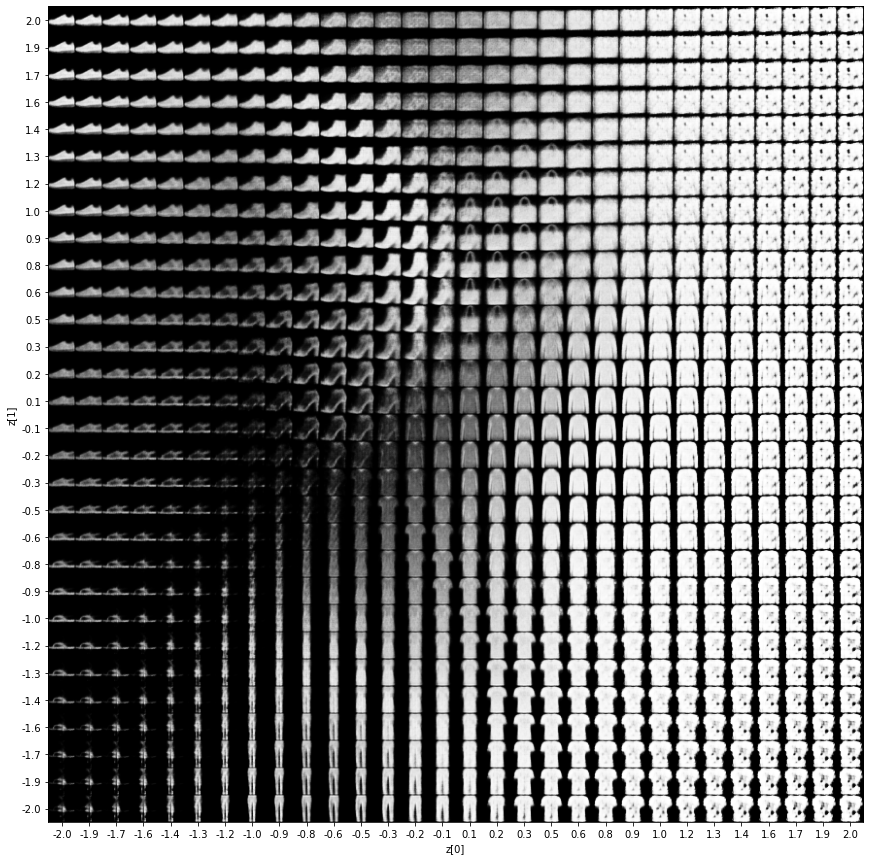

In [17]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


## Посмотрим на кластеры в скрытом пространстве


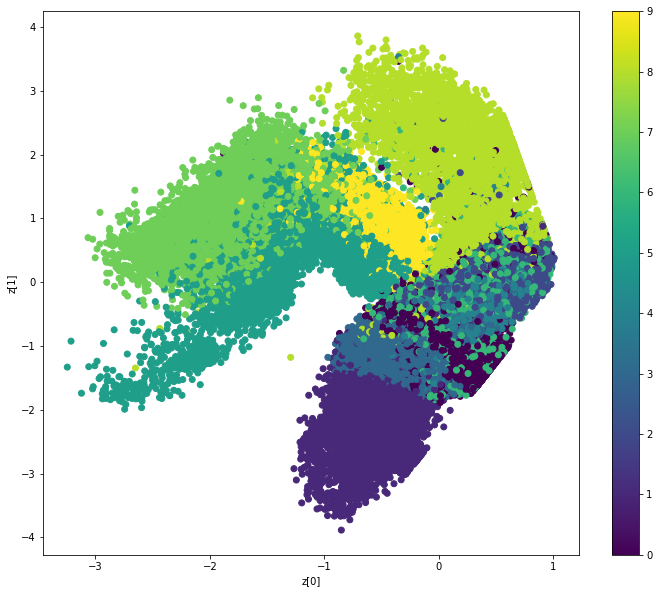

In [23]:

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)


Построим немного примеров генерации картинок:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

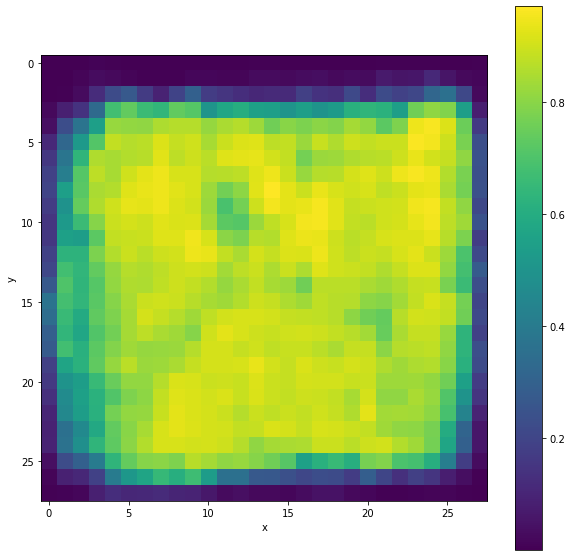

In [25]:

def plot_digit_from_decoder(decoder, z, digit_size):
    # display a 2D plot of the digit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    digit = decoder.predict(data)
    digit = digit.reshape(digit_size, digit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(digit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_digit_from_decoder(decoder, [1,1.6], 28)

2 Обзор статьи

https://ai.googleblog.com/2019/08/exploring-weight-agnostic-neural.html

Новая работа Google предлагает архитектуру нейронных сетей, способных имитировать врожденные инстинкты и рефлексы живых существ, с последующим дообучением в течении жизни. 
- уменьшит количество связей внутри сети, повышая тем самым их быстродействие
- Искусственные нейронные сети не могут имитировать мозг
- использование обучения с подкреплением (Reinforcement Learning) на практике работает не так хорошо
- Одним из самых заметных отличий биологического мозга от искусственных нейронных сетей является то, что структура живого мозга преднастроена миллионами лет эволюции. 
- не умаляя значения неокортекса (его, грубо говоря, при рождении можно считать аналогом случайно инициированных современных нейронных сетей), факты говорят о том, что даже у человека огромную роль играет заранее заданная структура мозга
-Но что еще важнее, нервная система всех живых существ оптимизирована для условий их жизни. Младенец не будет часами кричать, если голоден. Он устанет. Или испугается чего-то и замолчит. и тд И это не процесс обучения, а заранее заданное биологией поведение. Причем у разных видов разное
- Теоретически, современные способы обучения нейросетей способны из полносвязной сети создать подобие такого предобученного мозга, обнулив ненужные связи (по сути, обрезав их) и оставив только нужные. Но для этого нужно огромное количество примеров, неизвестно как их обучать, а главное — на данный момент не существует хороших способов зафиксировать эту “начальную” структуру мозга. Последующее обучение изменяет эти веса и все портится.

Исследователи из Google тоже задались этим вопросом. Нельзя ли создать начальную структуру мозга, аналогичную биологической, то есть уже хорошо оптимизированную для решения задачи, а потом лишь дообучить ее? Теоретически, это резко сузит пространство решений и позволит быстрее обучать нейросети.

К сожалению, существующие алгоритмы оптимизации структуры сети, такие как Neural Architecture Search (NAS), оперируют целыми блоками. После добавления или удаления которых, нейросеть приходится обучать заново с нуля. Это ресурсоемкий процесс и не полностью решает проблему.

Поэтому исследователи предложили упрощенную версию, которая получила название “Weight Agnostic Neural Networks” (WANN). Идея заключается в том, чтобы заменить все веса нейросети одним “общим” весом. И в процессе обучения подбирать не веса между нейронами, как в обычных нейросетях, а подбирать структуру самой сети (количество и расположение нейронов), которая с одинаковыми весами показывает наилучшие результаты. А после еще и оптимизировать ее, чтобы сеть хорошо работала со всеми возможными значениями этого общего веса (общим для всех соединений между нейронами!).

В итоге это дает структуру нейронной сети, которая не зависит от конкретных значений весов, а работает хорошо со всеми. Потому что работает за счет общей структуры сети. Это похоже на еще не инициализированный конкретными весами мозг животного при рождении, но уже содержащий вшитые инстинкты за счет своей общей структуры. А последующая тонкая настройка весов во время обучения в течении жизни, делает эту нейросеть еще лучше.

Побочным положительным эффектом такого подхода является значительное уменьшение числа нейронов в сети (так как остаются только наиболее важные соединения), что увеличивает ее быстродействие. 


Для поиска такой архитектуры исследователи воспользовались алгоритмом Topology search algorithm (NEAT). 
Сначала создается набор простых нейросетей, а потом делается одно из трех действий: 
добавляется новый нейрон в существующее соединение между двумя нейронами, 
добавляется новое соединение со случайными другим нейроном,
 либо меняется функция активации в нейроне. 
 
 А дальше, в отличие от классических NAS, где ищутся оптимальные веса между нейронами, здесь все веса инициализируются одним единственным числом. И оптимизация осуществляется для поиска структуры сети, которая лучше всех работает в широком диапазоне значений этого одного общего веса. Таким образом получается сеть, которая не зависит от конкретного веса между нейронами, а хорошо работает во всем диапазоне (но все веса по-прежнему инициируется одним числом, а не разными как в обычных сетях). При этом в качестве дополнительной цели для оптимизации стараются минимизировать число нейронов в сети.




создается популяция простых нейросетей
- каждая сеть инициализирует все свои веса одним числом, причем для широкого диапазона чисел: w=-2…+2
- полученные сети сортируются по качеству решения задачи и по числу нейронов (в сторону уменьшения)
- в части лучших представителей добавляется один нейрон, одна связь или меняется функция активации в одном нейроне
- эти модифицированные сети используются в качестве начальных в пункте 1)

но для нейронных сетей предложены сотни, если не тысячи разных идей. Работает ли это на практике? Да, работает.

Что характерно, дообучать можно как этот единственный общий вес, так как подбор архитектуры делается на ограниченном дискретном числе параметров. А получить можно в итоге более точный оптимальный параметр, скажем, 1.5. А можно лучший общий вес использовать как начальную точку для дообучения всех весов, как в классическом обучении нейросетей.

Это похоже на то, как обучаются животные. Имея при рождении близкие к оптимальным инстинкты, и используя эту заданную генами структуру мозга как начальную, в процессе своей жизни животные дообучают свой мозг под конкретные внешние условия. 
 

Другим вариантом использования WANN исследователи предлагают создавать ансамбли из WANN сетей. Так, обычная случайно инициализированная нейросеть на MNIST показывает точность около 10%. Подобранная единичная WANN нейросеть выдает около 80%, но ансамбль из WANN с разными общими весами, показывает уже >90%.

Как итог, предложенный исследователями из Google способ поиска начальной архитектуры оптимальной нейросети не только имитирует обучение животных (рождение со встроенными оптимальными инстинктами и дообучение в течении жизни), но также позволяет избежать симуляции всей жизни животных с полноценным обучением всей сети в классических эволюционных алгоритмах, создавая сразу простые и быстрые сети. Которые достаточно лишь слегка дообучить, чтобы получить полностью оптимальную нейросеть.